# Importación de Librerías y Carga de Datos

En esta primera sección, importamos las librerías necesarias para trabajar con los datos y los algoritmos de recomendación. También cargamos el dataset `steam-200k.csv` que contiene información sobre usuarios, juegos y horas jugadas.


In [109]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth, fpmax
from surprise import SVD, KNNBasic
from surprise import accuracy
from sklearn.linear_model import Perceptron
from surprise.model_selection import cross_validate
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import SGDClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Preprocesamiento de Datos

El dataset contiene varios tipos de comportamiento (por ejemplo, "play" y "purchase"). Nos enfocaremos solo en las interacciones donde los usuarios juegan ("play"). También normalizamos la columna `Hours` para que los valores estén entre 0 y 1, lo cual es útil para el modelo.


In [110]:
df = pd.read_csv('Bases\steam-200k.csv', names=['ID', 'Game', 'Behavior_name', 'Hours', '0'], index_col=0)

<>:1: DeprecationWarning:

invalid escape sequence '\s'

<>:1: DeprecationWarning:

invalid escape sequence '\s'

C:\Users\juano\AppData\Local\Temp\ipykernel_16780\149554118.py:1: DeprecationWarning:

invalid escape sequence '\s'



In [111]:
base = df.drop(columns=['0'])
datad =base.reset_index()
data = datad[datad['Behavior_name']=="play"]
data

,ID,Game,Behavior_name,Hours
1,151603712,The Elder Scrolls V Skyrim,play,273.0
3,151603712,Fallout 4,play,87.0
5,151603712,Spore,play,14.9
7,151603712,Fallout New Vegas,play,12.1
9,151603712,Left 4 Dead 2,play,8.9
...,...,...,...,...
199991,128470551,Fallen Earth,play,2.4
199993,128470551,Magic Duels,play,2.2
199995,128470551,Titan Souls,play,1.5
199997,128470551,Grand Theft Auto Vice City,play,1.5


In [112]:
data = data[['ID', 'Game', 'Hours']]

In [113]:
scaler = MinMaxScaler()
data['Escalado'] = scaler.fit_transform(data[['Hours']])

In [114]:
dataf = data.copy()

# Preparación para Modelos de Recomendación

Para el sistema de recomendación, necesitamos transformar los datos en un formato que Surprise pueda utilizar. Aquí, utilizamos un lector que trabaja con el rango de valores normalizados (0 a 1). Luego, dividimos los datos en conjuntos de entrenamiento y prueba.


In [115]:
reader = Reader(rating_scale=(0, 1))
data = Dataset.load_from_df(data[['ID', 'Game', 'Escalado']], reader)

In [116]:
trainset, testset = train_test_split(data, test_size=0.25)

# Entrenamiento del Modelo KNN

Entrenamos un modelo basado en KNN (K-Nearest Neighbors) para realizar recomendaciones. Este modelo utiliza la similitud entre usuarios para predecir cuántas horas podrían jugar a ciertos juegos.


In [117]:
model = KNNBasic()
model.fit(trainset)

predictions = model.test(testset)
accuracy.rmse(predictions)


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.0182


0.018162125723204435

# Análisis Descriptivo de los Datos

Realizamos una descripción estadística básica de los datos para entender mejor la distribución de horas jugadas y otras características importantes.


In [118]:
dataf.describe()


,ID,Hours,Escalado
count,7.048900e+04,70489.000000,70489.000000
mean,1.058812e+08,48.878063,0.004150
std,7.150365e+07,229.335236,0.019511
min,5.250000e+03,0.100000,0.000000
25%,4.934256e+07,1.000000,0.000077
50%,9.169067e+07,4.500000,0.000374
75%,1.556738e+08,19.100000,0.001616
max,3.099031e+08,11754.000000,1.000000


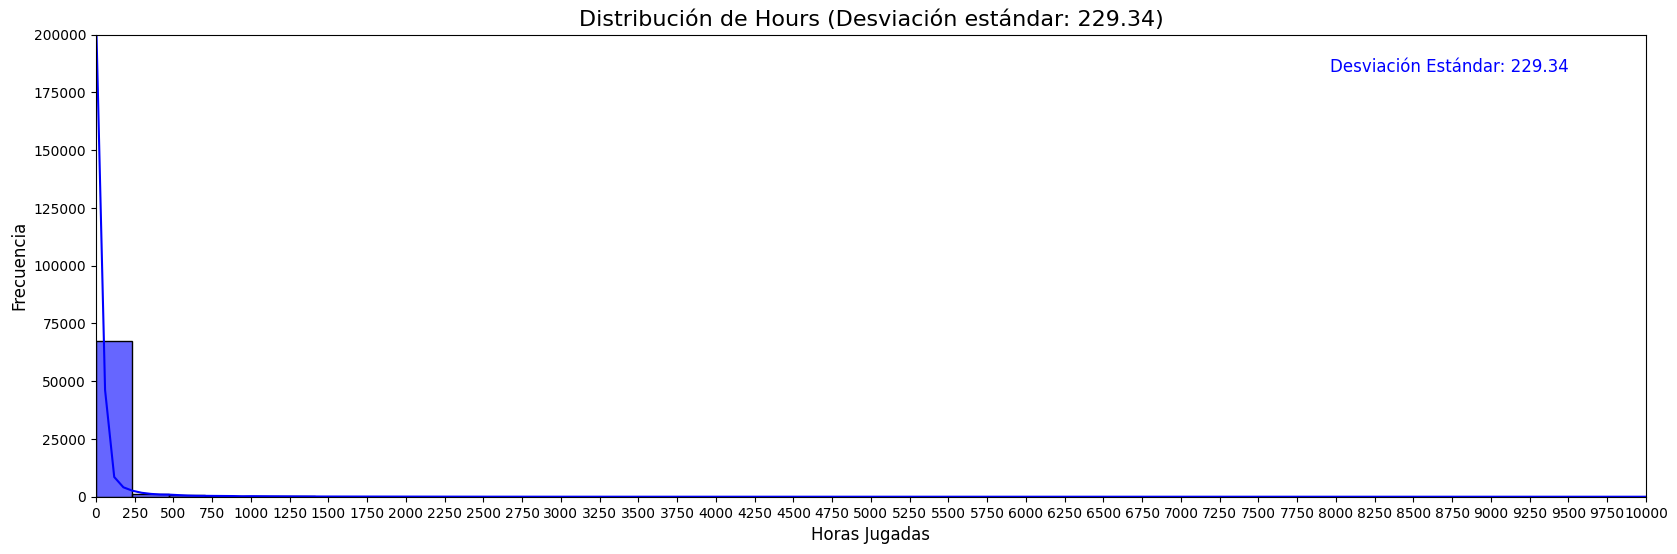

In [119]:
std_hours = dataf['Hours'].std()
plt.figure(figsize=(20, 6))
sns.histplot(dataf['Hours'], kde=True, bins=50, color='blue', label='Hours', alpha=0.6)
plt.title(f'Distribución de Hours (Desviación estándar: {std_hours:.2f})', fontsize=16)
plt.xlabel('Horas Jugadas', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)

plt.xlim(0, 10000) 
plt.xticks([i for i in range(0, 10000 + 250, 250)])

plt.ylim(0, 200000)

plt.text(0.95, 0.95, f'Desviación Estándar: {std_hours:.2f}', 
         horizontalalignment='right', verticalalignment='top', 
         transform=plt.gca().transAxes, fontsize=12, color='blue')

plt.show()

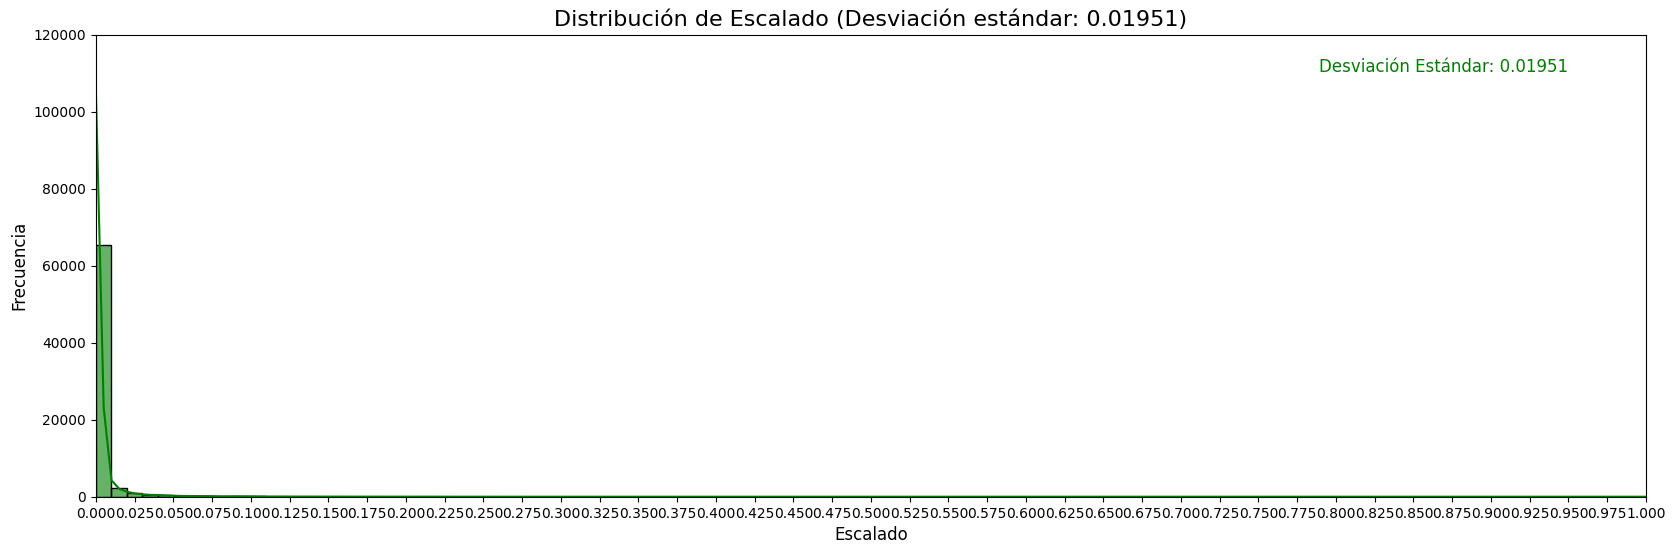

In [120]:
std_escalado = dataf['Escalado'].std()
plt.figure(figsize=(20, 6))
sns.histplot(dataf['Escalado'], kde=True, bins=100, color='green', label='Escalado', alpha=0.6)
plt.title(f'Distribución de Escalado (Desviación estándar: {std_escalado:.5f})', fontsize=16)
plt.xlabel('Escalado', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)

plt.xlim(0, 1)
plt.xticks([i for i in np.arange(0, 1 + 0.025, 0.025)])

plt.ylim(0, 120000)

plt.text(0.95, 0.95, f'Desviación Estándar: {std_escalado:.5f}', 
         horizontalalignment='right', verticalalignment='top', 
         transform=plt.gca().transAxes, fontsize=12, color='green')

plt.show()

# Prueba estableciendo la recomendación de 1 a 5

In [121]:
df = pd.read_csv('Bases\steam-200k.csv', names=['ID', 'Game', 'Behavior_name', 'Hours', '0'], index_col=0)
base = df.drop(columns=['0'])
datad =base.reset_index()
data = datad[datad['Behavior_name']=="play"]
data

<>:1: DeprecationWarning:

invalid escape sequence '\s'

<>:1: DeprecationWarning:

invalid escape sequence '\s'

C:\Users\juano\AppData\Local\Temp\ipykernel_16780\2311578986.py:1: DeprecationWarning:

invalid escape sequence '\s'



,ID,Game,Behavior_name,Hours
1,151603712,The Elder Scrolls V Skyrim,play,273.0
3,151603712,Fallout 4,play,87.0
5,151603712,Spore,play,14.9
7,151603712,Fallout New Vegas,play,12.1
9,151603712,Left 4 Dead 2,play,8.9
...,...,...,...,...
199991,128470551,Fallen Earth,play,2.4
199993,128470551,Magic Duels,play,2.2
199995,128470551,Titan Souls,play,1.5
199997,128470551,Grand Theft Auto Vice City,play,1.5


In [122]:
dset = Dataset.load_from_df(data[['ID','Game','Hours']], Reader(rating_scale=(1, 5)))

In [123]:
def convertir_a_calificacion(tiempo_jugado):
    if tiempo_jugado == 0:
        return 1  # El usuario no ha jugado el juego
    elif tiempo_jugado <= 1:
        return 2  # Jugó menos de 1 hora
    elif tiempo_jugado <= 5:
        return 3  # Jugó entre 1 y 5 horas
    elif tiempo_jugado <= 20:
        return 4  # Jugó entre 5 y 20 horas
    else:
        return 5  # Jugó más de 20 horas

data['calificacion'] = data['Hours'].apply(convertir_a_calificacion)

reader = Reader(rating_scale=(1, 5))
dset = Dataset.load_from_df(data[['ID', 'Game', 'calificacion']], reader)

C:\Users\juano\AppData\Local\Temp\ipykernel_16780\1204397360.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Prueba con (`KNNBasic()`)

In [124]:
trainset, testset = train_test_split(dset, test_size=0.25)

algo = KNNBasic()

algo.fit(trainset)

predictions = algo.test(testset)

accuracy.rmse(predictions)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.0114


1.0114160159077752

## Prueba con (`SVD()`)

In [125]:
from surprise import SVD

SVD = SVD()

SVD.fit(trainset)
pred = SVD.test(testset)

accuracy.rmse(pred)

RMSE: 0.9775


0.977512951260375

## Prueba con (`KNNWithMeas()`)

In [126]:
from surprise import KNNWithMeans

algo = KNNWithMeans()

algo.fit(trainset)
predictions = algo.test(testset)

accuracy.rmse(predictions)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.0342


1.0341540504870246

# Modelos de Clasificación para el Dataset de Fallos Cardíacos

En esta sección, trabajamos con un segundo dataset (`heart_failure_clinical_records_dataset.csv`) que contiene registros clínicos sobre fallos cardíacos. Implementamos tres modelos de clasificación binaria: Perceptrón, ADALINE y Regresión Logística. Estos modelos son útiles para predecir si un paciente fallecerá a partir de diversas características clínicas.


In [127]:
data = pd.read_csv('Bases\heart_failure_clinical_records_dataset.csv')
data.head()

from sklearn.model_selection import train_test_split
X = data.drop(columns=['DEATH_EVENT'])
y = data['DEATH_EVENT']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


<>:1: DeprecationWarning:

invalid escape sequence '\h'

<>:1: DeprecationWarning:

invalid escape sequence '\h'

C:\Users\juano\AppData\Local\Temp\ipykernel_16780\1153065988.py:1: DeprecationWarning:

invalid escape sequence '\h'



# Entrenamiento del Modelo Perceptrón

Entrenamos un modelo de Perceptrón utilizando los datos de entrenamiento. El Perceptrón es un tipo de red neuronal simple que es especialmente útil para tareas de clasificación binaria.


In [128]:
perceptron = Perceptron(max_iter=1000)
perceptron.fit(X_train, y_train)
y_pred_perceptron = perceptron.predict(X_test)


# Entrenamiento del Modelo ADALINE

El modelo ADALINE (Adaptive Linear Neuron) es una extensión del Perceptrón, y lo entrenamos con los mismos datos. Utiliza una función de pérdida cuadrática y un método de descenso de gradiente estocástico.


In [129]:
adaline = SGDClassifier(loss='perceptron', max_iter=1000, eta0=0.001, learning_rate='constant')
adaline.fit(X_train, y_train)
y_pred_adaline = adaline.predict(X_test)


# Entrenamiento del Modelo de Regresión Logística

El modelo de Regresión Logística es otro enfoque para la clasificación binaria. A diferencia del Perceptrón y ADALINE, este modelo estima probabilidades, lo que le permite manejar mejor datos ruidosos.


In [130]:
logistic = LogisticRegression()
logistic.fit(X_train, y_train)
y_pred_logistic = logistic.predict(X_test)


C:\Users\juano\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



# Evaluación de los Modelos

Finalmente, comparamos los tres modelos (Perceptrón, ADALINE y Regresión Logística) utilizando un informe de clasificación, que incluye métricas como la precisión, recall, f1-score y más.


In [131]:
print("Perceptron:\n", classification_report(y_test, y_pred_perceptron))
print("ADALINE:\n", classification_report(y_test, y_pred_adaline))
print("Regresión Logística:\n", classification_report(y_test, y_pred_logistic))


Perceptron:
               precision    recall  f1-score   support

           0       0.58      1.00      0.74        35
           1       0.00      0.00      0.00        25

    accuracy                           0.58        60
   macro avg       0.29      0.50      0.37        60
weighted avg       0.34      0.58      0.43        60

ADALINE:
               precision    recall  f1-score   support

           0       0.58      1.00      0.74        35
           1       0.00      0.00      0.00        25

    accuracy                           0.58        60
   macro avg       0.29      0.50      0.37        60
weighted avg       0.34      0.58      0.43        60

Regresión Logística:
               precision    recall  f1-score   support

           0       0.77      0.97      0.86        35
           1       0.94      0.60      0.73        25

    accuracy                           0.82        60
   macro avg       0.86      0.79      0.80        60
weighted avg       0.84      

C:\Users\juano\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\juano\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\juano\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` pa